## Loading training data

In [2]:
import pandas as pd
import numpy as np

data = pd.read_parquet("train-00000-of-00001-c08a401c53fe5312.parquet") 
data.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


## Class imbalance

In [4]:
data["label"].value_counts()

label
2    2566
3    1781
0     724
1      49
Name: count, dtype: int64

In [5]:
label_to_class_mapping = {0: "Mild_Demented", 1: "Moderate_Demented", 2: "Non_Demented",3: "Very_Mild_Demented"}
data["class"] = data["label"].map(label_to_class_mapping)
data.head()

,image,label,class
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,Non_Demented
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0,Mild_Demented
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,Very_Mild_Demented
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3,Very_Mild_Demented
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2,Non_Demented


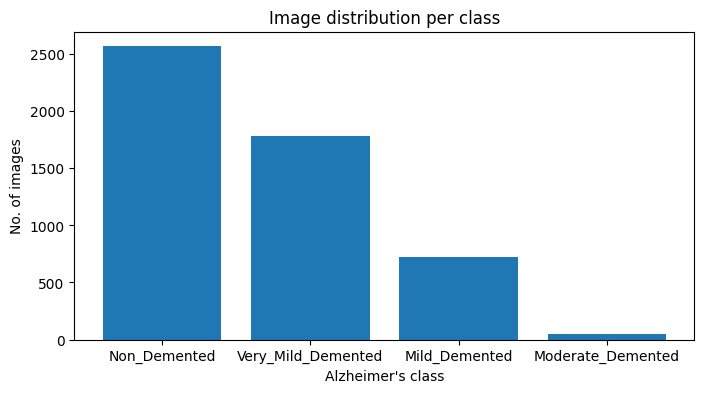

In [6]:
import matplotlib.pyplot as plt

count = data.value_counts("class")

x = count.index
y = count.iloc[:]

fig = plt.figure(figsize=(8, 4))
plt.bar(x, y)
plt.xlabel("Alzheimer's class")
plt.ylabel("No. of images")
plt.title("Image distribution per class")
plt.show()

## Data augmentation

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import io
from sklearn.model_selection import train_test_split

def bytes_to_image(image_bytes):
    img = Image.open(io.BytesIO(image_bytes))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis = -1)
    return img_array

data_agu = data[data["label"].isin([0,1])].copy()
data_other = data[data["label"].isin([2,3])].copy()

data_other["image_arr"] = data_other["image"].apply(lambda img_dict: bytes_to_image(img_dict["bytes"]))

datagen = ImageDataGenerator(rotation_range = 50, width_shift_range = 0.3, height_shift_range = 0.3, shear_range = 0.4, 
                             zoom_range = 0.6, horizontal_flip = True, fill_mode = "nearest")

augmented_images = []
augmented_labels = []

label_counts = data_agu['label'].value_counts()
max_count = label_counts.max()
new_label_counts = label_counts.copy()

for index, row in data_agu.iterrows():
    image_bytes = row["image"]["bytes"]
    label = row["label"]
    
    img_array = bytes_to_image(image_bytes)
    img_array = np.expand_dims(img_array, axis = 0)
    
    current_count = new_label_counts[label]
    if label == 1:
        augment_count = max(500, max_count - current_count)
    else:
        augment_count = max(200, max_count - current_count)
    
    for i in range(augment_count):
        aug_iter = datagen.flow(img_array, batch_size = 1)
        aug_img = next(aug_iter)[0]
        
        augmented_images.append(aug_img)
        augmented_labels.append(label)
        
        new_label_counts[label] += 1
        if new_label_counts[label] >= max_count:
            break

data_agu["image_arr"] = data_agu["image"].apply(lambda img_dict: bytes_to_image(img_dict["bytes"]))

data_augmented_img = pd.DataFrame({"image_arr": augmented_images, "label": augmented_labels})

data_final = pd.concat([data_other, data_agu[["image_arr", "label"]], data_augmented_img], ignore_index = True)

print(f"Original dataset size: {len(data)}")
print(f"Augmented dataset size: {len(data_final)}")
print(data_final["label"].value_counts())

X = np.array(data_final["image_arr"].to_list(), dtype = np.float32)
y = np.array(data_final["label"])

y_onehot = tf.keras.utils.to_categorical(y, num_classes=4)

X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size = 0.2, random_state = 42, stratify = y)

X_train = X_train.reshape(-1, 128, 128, 1)
X_val = X_val.reshape(-1, 128, 128, 1)

Original dataset size: 5120
Augmented dataset size: 6567
label
2    2566
3    1781
0    1448
1     772
Name: count, dtype: int64


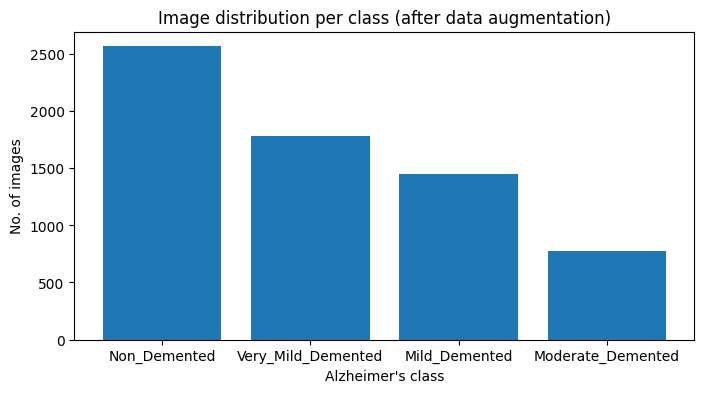

In [9]:
data_final["class"] = data_final["label"].map(label_to_class_mapping)
count = data_final.value_counts("class")

x = count.index
y = count.iloc[:]

fig = plt.figure(figsize=(8, 4))
plt.bar(x, y)
plt.xlabel("Alzheimer's class")
plt.ylabel("No. of images")
plt.title("Image distribution per class (after data augmentation)")
plt.show()

In [10]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight("balanced", classes = np.array([0, 1, 2, 3]), y = data_final["label"])
class_weights = dict(enumerate(class_weights))

class_weights[1] *= 1.0

print("Updated class weights:", class_weights)

Updated class weights: {0: 1.1338052486187846, 1: 2.1266191709844557, 2: 0.6398090413094311, 3: 0.9218135878719821}


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model = Sequential([
    layers.Conv2D(128, (3, 3), activation = "relu", input_shape = (128, 128, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation = "relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation = "relu"),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation = "relu"),
    layers.Dense(4, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True)

model.summary()

C:\Users\Anjana\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,996 (3.42 MB)

 Trainable params: 896,996 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_val, y_val), callbacks = [early_stop], class_weight = class_weights)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.4292 - loss: 1.0999 - val_accuracy: 0.5221 - val_loss: 0.9329
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.5697 - loss: 0.8632 - val_accuracy: 0.5510 - val_loss: 0.8624
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.6212 - loss: 0.7569 - val_accuracy: 0.6248 - val_loss: 0.7450
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.7049 - loss: 0.6224 - val_accuracy: 0.6796 - val_loss: 0.6777
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.7828 - loss: 0.4589 - val_accuracy: 0.6766 - val_loss: 0.7039
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.8631 - loss: 0.3181 - val_accuracy: 0.7610 - val_loss: 0.5615
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9159 - loss: 0.1978 - val_accuracy: 0.7983 - val_loss: 0.5143
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9587 - loss: 0.1025 - val_accu

## Model evaluation

In [49]:
model.evaluate(X_val, y_val)

42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - accuracy: 0.8336 - loss: 0.5350


[0.5086608529090881, 0.835616409778595]

42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 346ms/step
              precision    recall  f1-score   support

           0       0.79      0.72      0.75       290
           1       0.62      0.75      0.68       155
           2       0.93      0.89      0.91       513
           3       0.85      0.89      0.87       356

    accuracy                           0.84      1314
   macro avg       0.80      0.81      0.80      1314
weighted avg       0.84      0.84      0.84      1314



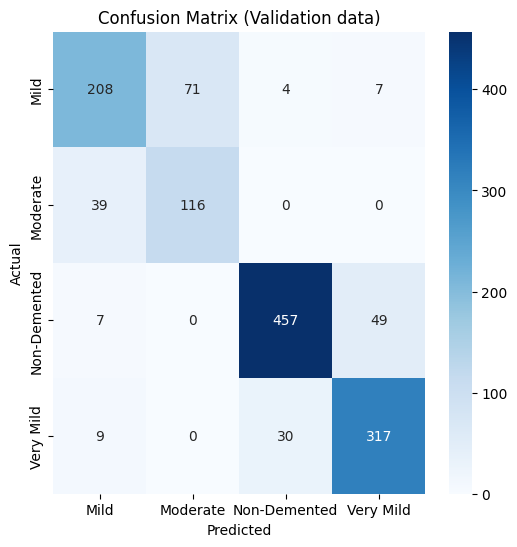

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
print(classification_report(y_true, y_pred))

plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Mild", "Moderate", "Non-Demented", "Very Mild"],
            yticklabels = ["Mild", "Moderate", "Non-Demented", "Very Mild"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation data)")
plt.show()

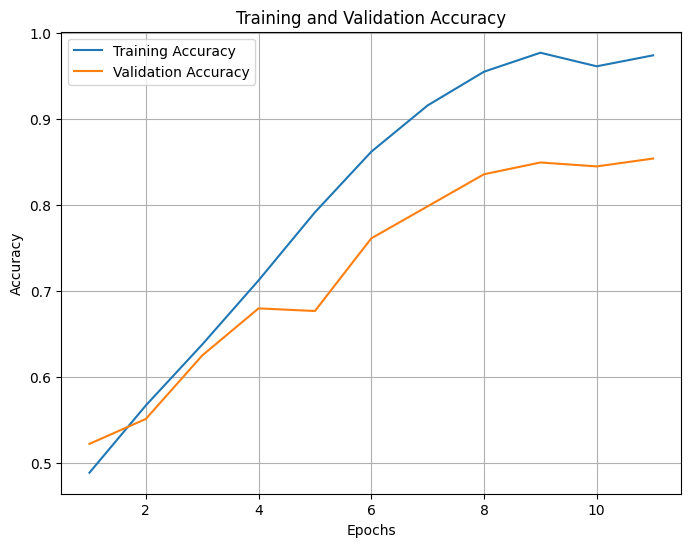

In [53]:
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize = (8, 6))
plt.plot(epochs, train_accuracy, label = "Training Accuracy")
plt.plot(epochs, val_accuracy, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

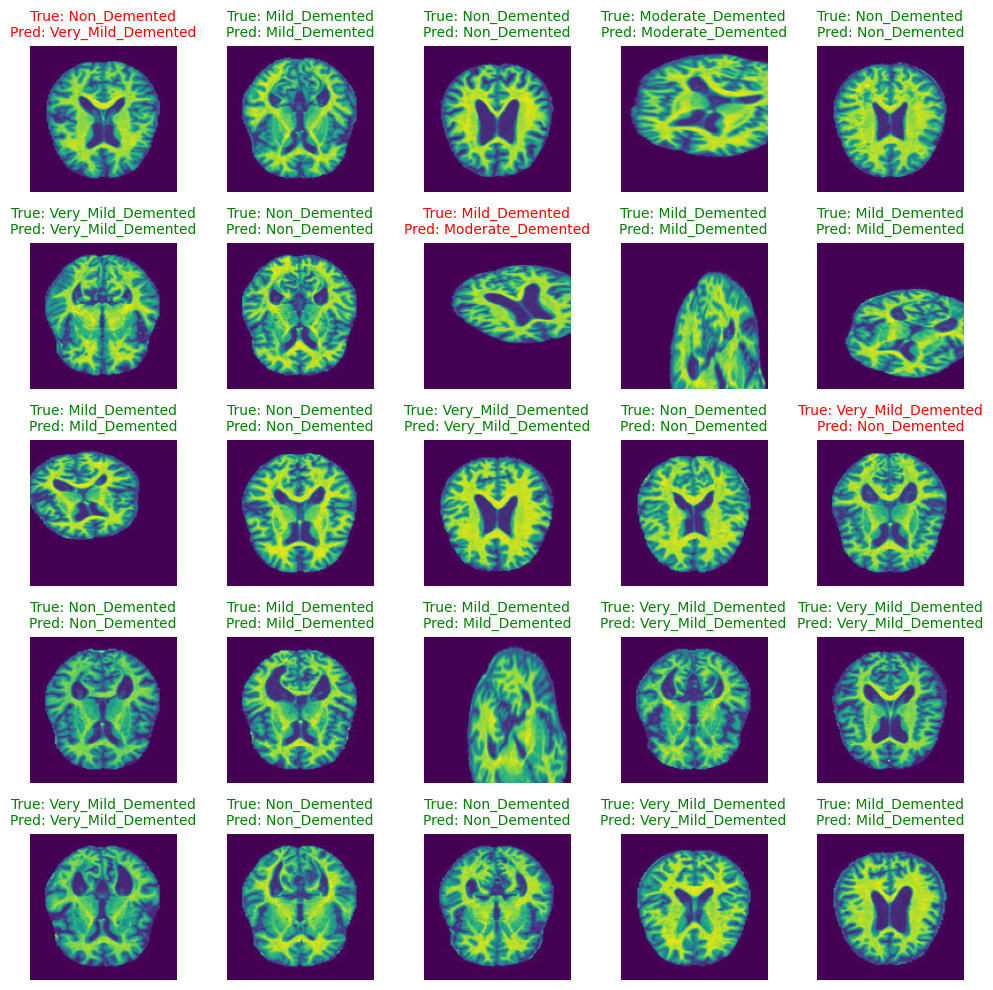

In [59]:
indices = np.random.choice(X_val.shape[0], 25, replace=False)
images = X_val[indices]
true_labels = y_true[indices]
pred_labels = y_pred[indices]

fig, ax = plt.subplots(5, 5, figsize = (10, 10))
for ax, img, true_label, pred_label in zip(ax.flat, images, true_labels, pred_labels):
    ax.imshow(img)
    ax.set_title(f"True: {label_to_class_mapping[true_label]}\nPred: {label_to_class_mapping[pred_label]}", fontsize = 10, color = "green" if (true_label == pred_label) else "red")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Model prediction

In [61]:
test_data = pd.read_parquet("test-00000-of-00001-44110b9df98c5585.parquet") 
test_data.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [63]:
test_data["img_arr"] = test_data["image"].apply(lambda img_dict: bytes_to_image(img_dict['bytes']))
test_data.drop("image", axis = 1, inplace = True)
test_data.head()

,label,img_arr
0,3,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,2,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,3,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [65]:
test_data["class"] = test_data["label"].map(label_to_class_mapping)
test_data.head()

,label,img_arr,class
0,3,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",Very_Mild_Demented
1,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",Mild_Demented
2,2,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",Non_Demented
3,3,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",Very_Mild_Demented
4,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",Mild_Demented


40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       172
           1       0.93      0.93      0.93        15
           2       0.95      0.89      0.92       634
           3       0.86      0.93      0.90       459

    accuracy                           0.91      1280
   macro avg       0.91      0.91      0.91      1280
weighted avg       0.91      0.91      0.91      1280



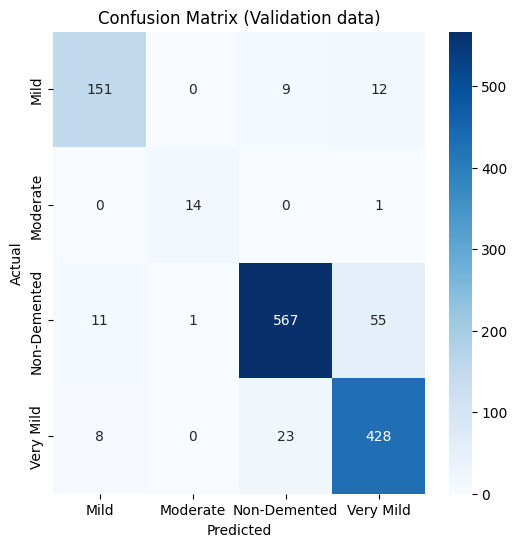

In [67]:
X_test = np.stack(test_data["img_arr"].values)
y_test = test_data["label"].values

X_test = X_test.reshape(-1, 128, 128, 1)

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Mild", "Moderate", "Non-Demented", "Very Mild"],
            yticklabels = ["Mild", "Moderate", "Non-Demented", "Very Mild"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation data)")
plt.show()

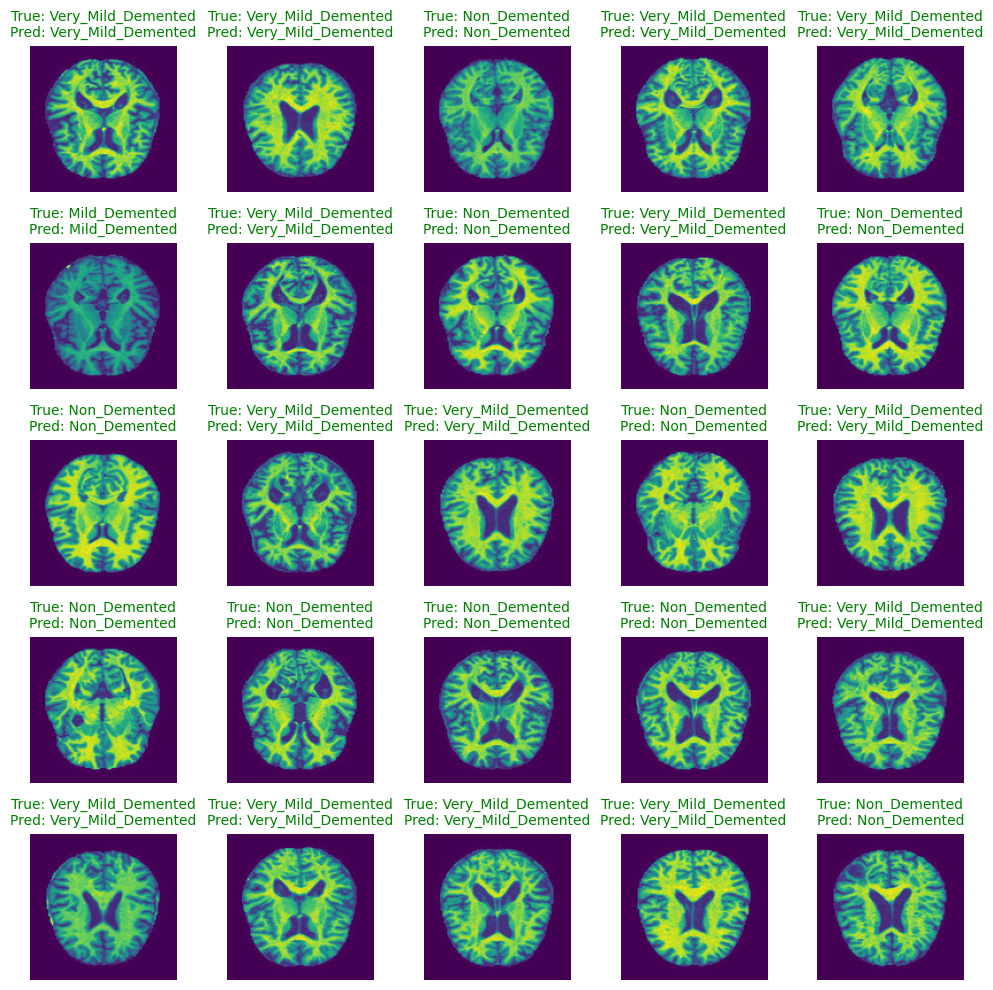

In [69]:
indices = np.random.choice(X_test.shape[0], 25, replace=False)
images = X_test[indices]
true_labels = y_test[indices]
pred_labels = y_pred[indices]

fig, ax = plt.subplots(5, 5, figsize = (10, 10))
for ax, img, true_label, pred_label in zip(ax.flat, images, true_labels, pred_labels):
    ax.imshow(img)
    ax.set_title(f"True: {label_to_class_mapping[true_label]}\nPred: {label_to_class_mapping[pred_label]}", fontsize = 10, color = "green" if (true_label == pred_label) else "red")
    ax.axis('off')

plt.tight_layout()
plt.show()